### Training MLP classifier

In [6]:
import pandas as pd

df_embedding = pd.read_json('../../data/embedded_train.jl', lines=True)
# df_embedding = pd.read_json('../../data/embedded_train_clean.jl', lines=True)
df_embedding.loc[df_embedding["target"] == "NA", ["target"]] = 0  # added

df_embedding['target'] = df_embedding['target'].astype(str)
df_embedding = df_embedding.rename(columns={'id':'id_str'})
df_embedding['id_str'] = df_embedding['id_str'].astype(str)

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_embedding["target"])
df_embedding["target_label"] = df_embedding["target"].apply(lambda x: le.transform([x])[0])

{'-1': 0, '0': 1, '1': 2}


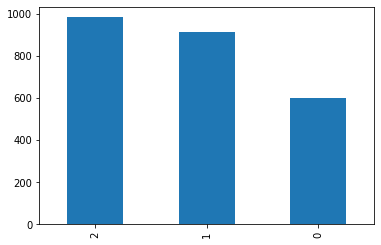

In [8]:
import matplotlib

print(dict(zip(le.classes_, range(len(le.classes_)))))
df_embedding["target_label"].value_counts().plot.bar();

In [35]:
%load_ext tensorboard

%tensorboard --logdir lightning_logs/ --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from typing import Optional, Tuple


class TweetsDataModule(pl.LightningDataModule):

    def __init__(self, data_path: str="../../data", test_size: float=0.2, batch_size: int=128):
        super().__init__()
        self.data_path = data_path
        self.test_size = test_size
        self.batch_size = batch_size
        self.sample_map = None
        self.le = LabelEncoder()
        self.ss = StandardScaler()
        # self.pca = PCA(213)  # compress to 213 features explaining 98% variance
        # self.pca = PCA(173)  # compress to 173 features explaining 95% variance


    def process_data(self, data):
        self.le.fit(data["target"])
        y = data["target"].apply(lambda x: self.le.transform([x])[0])

        X = pd.DataFrame(data["embedding"].tolist())
        X = self.ss.fit_transform(X)
        X = pd.concat([pd.DataFrame(X), data["id_str"]], axis=1)

        return X, y

    def calc_sample_map(self, data):
        self.sample_map = {idx: sample_id for idx, sample_id in enumerate(data["id_str"].values.tolist())}
        return data.drop("id_str", axis=1)


    def format_data(self, data):
        return torch.from_numpy(np.vstack(data)).float()


    def make_pca(self, train, test):
        # self.pca.fit(train)
        # train = self.pca.transform(train)
        # test = self.pca.transform(test)

        train = pd.DataFrame(train).values.tolist()
        test = pd.DataFrame(test).values.tolist()

        return train, test


    def setup(self, stage: Optional[str] = None):
        data = pd.read_json(self.data_path, lines=True)
        data.loc[df_embedding["target"] == "NA", ["target"]] = 0  # added

        # added for new data
        data['target'] = df_embedding['target'].astype(str)
        data = df_embedding.rename(columns={'id':'id_str'})
        data['id_str'] = df_embedding['id_str'].astype(str)

        X, y = self.process_data(data)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        X_train = self.calc_sample_map(X_train)
        X_test = X_test.drop("id_str", axis=1)

        X_train, X_test = self.make_pca(X_train, X_test)
        self.X_train = self.format_data(X_train)
        self.X_test = self.format_data(X_test)
        self.y_train = self.format_data(y_train)
        self.y_test = self.format_data(y_test)
        
    
    def train_dataloader(self):
        return DataLoader(TensorDataset(self.X_train, self.y_train), batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.X_test, self.y_test), batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.X_test, self.y_test), batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(TensorDataset(self.X_test, self.y_test), batch_size=self.batch_size)

    def get_test_sets(self):
        return self.X_test, self.y_test

    def get_batch_size(self):
        return self.batch_size
    
    def get_label_encoder(self):
        return self.le

    def get_sample_map(self):
        return self.sample_map

In [31]:
from sklearn.metrics import f1_score, accuracy_score
import torch.nn as nn


class MLP(pl.LightningModule):
  
  def __init__(self, input_dim, hidden_dim, output_dim, lr=1e-4):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.lr = lr
    
    self.layers = nn.Sequential(
      nn.Linear(input_dim, hidden_dim),
      nn.ReLU(),
      # nn.Linear(hidden_dim, hidden_dim),
      # nn.ReLU(),
      nn.Linear(hidden_dim, out_features=output_dim),
      nn.Softmax(dim=1)
    )
    self.loss = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.layers(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    y = y.flatten().type(torch.LongTensor)
    y_hat = self(x)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss, on_epoch=True, on_step=False)
    return {"loss": loss, "logits": y_hat.detach(), "gold": y, "batch_idx": batch_idx}

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y = y.flatten().type(torch.LongTensor)
    y_hat = self(x)
    loss = self.loss(y_hat, y)
    y_hat = torch.argmax(self(x), 1)
    f1 = f1_score(y.cpu(), y_hat.cpu(), average='micro')
    acc = accuracy_score(y.cpu(), y_hat.cpu())
    self.log("val_loss", loss, prog_bar=True)
    self.log("val_f1_micro", f1, prog_bar=True)
    self.log("val_acc", acc, prog_bar=True)
    return loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y = y.flatten().type(torch.LongTensor)
    y_hat = self(x)
    y_hat = torch.argmax(self(x), 1)

    report = classification_report(y, y_hat, output_dict=True)
    self.log_dict(report)
    return report

  def training_epoch_end(self, outputs):
      batch_size = self.trainer.datamodule.get_batch_size()
      sample_map = self.trainer.datamodule.get_sample_map()

      data = {"guid": [], f"logits_epoch_{self.current_epoch}": [], "gold": []}
      for batch in outputs:
        batch_idx = batch["batch_idx"]
        curr_batch_size = len(batch["logits"])
        data["guid"] += [sample_map[batch_size*batch_idx + idx] for idx in range(curr_batch_size)]
        data[f"logits_epoch_{self.current_epoch}"] += batch["logits"].tolist()
        data["gold"] += batch["gold"].tolist()

      df = pd.DataFrame(data)
      df.to_json(f"./training_dynamics/dynamics_epoch_{self.current_epoch}.jsonl", lines=True, orient='records')

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

  def predict_step(
    self,
    batch,
    batch_idx: int,
    dataloader_idx: Optional[int] = None,
  ) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = batch
    z = self(x)
    return z, y

In [33]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers


def train_model(dataloader, name, epochs=40, lr=1e-4):
    AVAIL_GPUS = min(1, torch.cuda.device_count())
    model = MLP(
    #   input_dim=213,  # 768
      input_dim=768,
      hidden_dim=768,
      output_dim=3,  # 4
      lr=lr
    )
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="../../data/mlp/",
        filename=name,
        save_top_k=1,
        mode="min",
    )
    tb_logger = pl_loggers.TensorBoardLogger("lightning_logs/", name=name, log_graph=True)
    trainer = pl.Trainer(
        max_epochs=epochs,
        gpus=AVAIL_GPUS,
        callbacks=[checkpoint_callback],
        logger=tb_logger,
    )
    trainer.fit(model, dataloader)

    return trainer

In [34]:
# data = TweetsDataModule(data_path='../../data/embedded_train.jl', batch_size=32)
# data = TweetsDataModule(data_path='../../data/embedded_train_150.jl', batch_size=32)
data = TweetsDataModule(data_path='../../data/embedded_train_150.jl', batch_size=32)

# data = TweetsDataModule(data_path='../../data/embedded_train_clean.jl', batch_size=32)
# trainer = train_model(data, 'mlp_demoji150_3c_pca_209_209_bs=32_lr-4', epochs=20, lr=1e-4)
trainer = train_model(data, 'test_no_pca', epochs=20, lr=1e-4)
# clear training_dynamics when changing epochs number

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: lightning_logs/test_no_pca

  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 592 K 
1 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
592 K     Trainable params
0         Non-trainable params
592 K     Total params
2.372     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 47.76it/s, loss=0.622, v_num=0, val_loss=0.852, val_f1_micro=0.678, val_acc=0.678]


#### Model evaluation

In [36]:
def tf_count(t, val):
    return t.tolist().count(0)

In [39]:
import numpy as np
from sklearn.metrics import classification_report

def test_model(model, X, y, le):
    model.eval()
    with torch.no_grad():
        preds = model(X)
    preds = torch.argmax(preds, 1)
    # print(tf_count(preds, 0))

    return classification_report(y, preds, zero_division=0, target_names=le.classes_) 

In [40]:
# data = TweetsDataModule(data_path='../../data/embedded_train.jl')
# rainer.test(model=mlp, dataloaders=data)

In [41]:
X_test, y_test = data.get_test_sets()
le = data.get_label_encoder()
# mlp = MLP.load_from_checkpoint(checkpoint_path=f'../../data/mlp/mlp_newdata_3c_pca_213_213_bs=32_lr-4.ckpt', input_dim=213, hidden_dim=213, output_dim=3)
mlp = MLP.load_from_checkpoint(checkpoint_path=f'../../data/mlp/test_no_pca.ckpt', input_dim=768, hidden_dim=768, output_dim=3)
report = test_model(mlp, X_test, y_test, le)
print(report)

              precision    recall  f1-score   support

          -1       0.62      0.59      0.61       120
           0       0.68      0.70      0.69       183
           1       0.71      0.71      0.71       197

    accuracy                           0.68       500
   macro avg       0.67      0.67      0.67       500
weighted avg       0.68      0.68      0.68       500



0.0     239
1.0     156
-1.0    105
dtype: int64


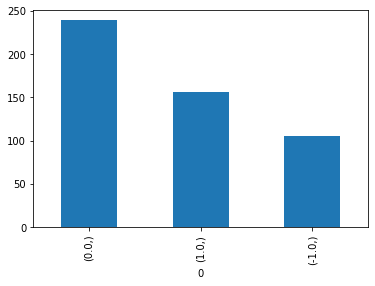

In [47]:
df = pd.DataFrame(le.inverse_transform(np.array(y_test.flatten(), dtype='int32')))
print(df.value_counts())
df.value_counts().plot.bar();